In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
def load_data(directory):
    data = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            data.append(df)
    return pd.concat(data, ignore_index=True)

df = load_data('data/cic')
# Clean column names (in case of whitespace)
df.columns = df.columns.str.strip()

df = df[df['Label'] != 'BENIGN']

features = df.select_dtypes(include=[np.number]).copy()
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
df = df.loc[features.index].copy()

100%|██████████| 8/8 [00:13<00:00,  1.73s/it]


In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
def group_attack_label(label):
    if label == "BENIGN":
        return "Benign"
    elif "DoS" in label or label == "DDoS":
        return "DoS/DDoS"
    elif "PortScan" in label:
        return "Scan"
    elif "Patator" in label:
        return "BruteForce"
    elif "Web Attack" in label:
        return "WebAttack"
    elif label in ["Bot", "Infiltration", "Heartbleed"]:
        return "Other"
    else:
        return "Unknown"

df['label_group'] = df['Label'].apply(group_attack_label)

In [5]:
df = df.loc[:, ~df.columns.str.contains('bwd', case=False)]
df = df.loc[:, ~df.columns.str.contains('backward', case=False)]


In [6]:
import pickle
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)

In [7]:
cic_columns = grouped_df.filter(regex='^cic').columns
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]
grouped_df_cic = grouped_df[cic_columns]

In [8]:
feature_mapping = [
    ('Destination Port', 'cic_Destination Port'),
    ('Flow Duration', 'cic_Flow Duration'),
    ('Total Fwd Packets', 'cic_Total Fwd Packets'),
    ('Total Length of Fwd Packets', 'cic_Total Length of Fwd Packets'),
    ('Fwd Packet Length Max', 'cic_Fwd Packet Length Max'),
    ('Fwd Packet Length Min', 'cic_Fwd Packet Length Min'),
    ('Fwd Packet Length Mean', 'cic_Fwd Packet Length Mean'),
    ('Fwd Packet Length Std', 'cic_Fwd Packet Length Std'),
    ('Flow Bytes/s', 'cic_Flow Bytes/s'),
    ('Flow Packets/s', 'cic_Flow Packets/s'),
    ('Flow IAT Mean', 'cic_Flow IAT Mean'),
    ('Flow IAT Std', 'cic_Flow IAT Std'),
    ('Flow IAT Max', 'cic_Flow IAT Max'),
    ('Flow IAT Min', 'cic_Flow IAT Min'),
    ('Fwd IAT Total', 'cic_Fwd IAT Total'),
    ('Fwd IAT Mean', 'cic_Fwd IAT Mean'),
    ('Fwd IAT Std', 'cic_Fwd IAT Std'),
    ('Fwd IAT Max', 'cic_Fwd IAT Max'),
    ('Fwd IAT Min', 'cic_Fwd IAT Min'),
    ('Fwd Packets/s', 'cic_Fwd Packets/s'),
    ('Min Packet Length', 'cic_Min Packet Length'),
    ('Max Packet Length', 'cic_Max Packet Length'),
    ('Packet Length Mean', 'cic_Packet Length Mean'),
    ('Packet Length Std', 'cic_Packet Length Std'),
    ('Packet Length Variance', 'cic_Packet Length Variance'),
    ('Average Packet Size', 'cic_Average Packet Size'),
    ('Avg Fwd Segment Size', 'cic_Avg Fwd Segment Size')
]

rename_dict = {cic_name: new_name for new_name, cic_name in feature_mapping}
grouped_df_cic.rename(columns=rename_dict, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_12428\2453699586.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cic.rename(columns=rename_dict, inplace=True)


In [9]:
columns = list(grouped_df_cic.columns)
columns.append("label_group")
df = df[columns]

# prepare the data 
- x_train x_test ect
- the omni dataset to make predictions on

In [10]:
le = LabelEncoder()

df['label_group_encoded'] = le.fit_transform(df['label_group'])
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")
print("\nUnique encoded values:", df['label_group_encoded'].unique())
print("Original labels:", df['label_group'].unique())
df.drop(columns=["label_group"], inplace=True)

BruteForce: 0
DoS/DDoS: 1
Other: 2
Scan: 3
WebAttack: 4

Unique encoded values: [1 3 2 4 0]
Original labels: ['DoS/DDoS' 'Scan' 'Other' 'WebAttack' 'BruteForce']


In [11]:
x = df.drop(columns=["label_group_encoded"])
y = df["label_group_encoded"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
x_grouped = grouped_df_cic.copy()

scaler = QuantileTransformer()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_grouped = pd.DataFrame(scaler.transform(x_grouped), columns=x.columns)

## XGB

In [12]:
from xgboost import XGBClassifier

In [13]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgb.fit(x_train, y_train)

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:21:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [27]:
pred = xgb.predict(x_test)

omni_pred = xgb.predict(x_grouped)
omni_probs = xgb.predict_proba(x_grouped)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2834
           1       1.00      1.00      1.00     75746
           2       0.98      0.99      0.99       388
           3       1.00      1.00      1.00     31850
           4       1.00      0.90      0.94       494

    accuracy                           1.00    111312
   macro avg       0.99      0.98      0.98    111312
weighted avg       1.00      1.00      1.00    111312



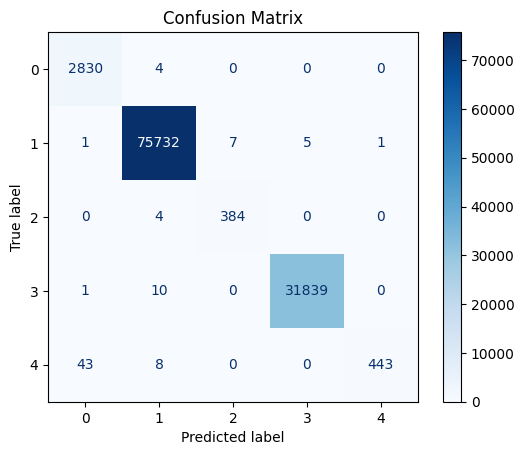

In [15]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [16]:
pd.Series(omni_pred).value_counts()

1    224667
0    203291
2      1904
3        30
Name: count, dtype: int64

## PCA

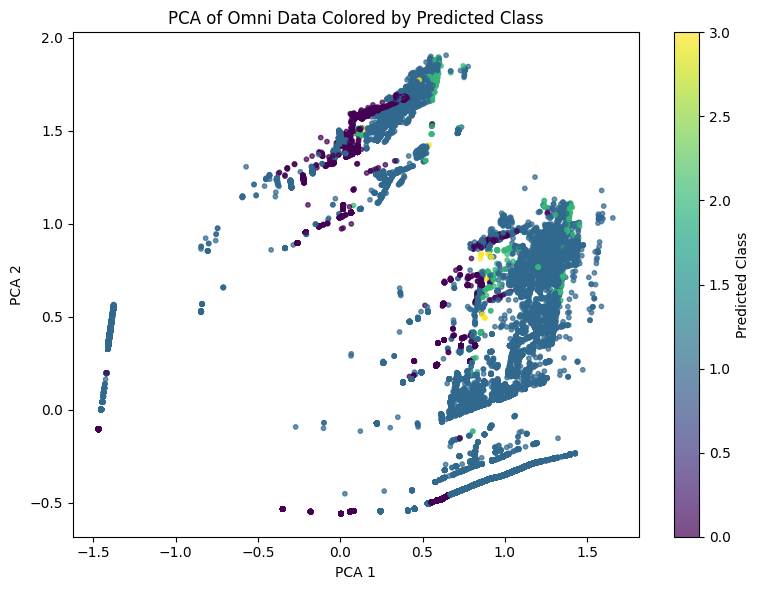

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

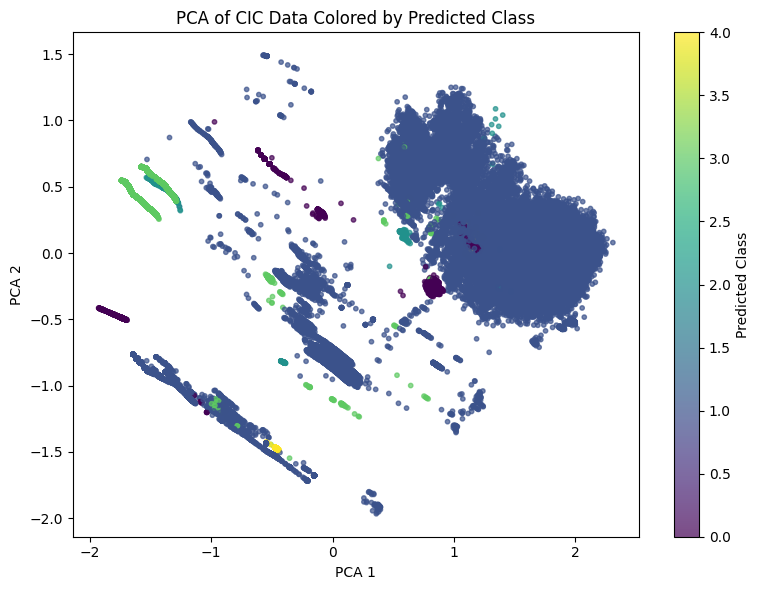

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of CIC Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

## umap

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

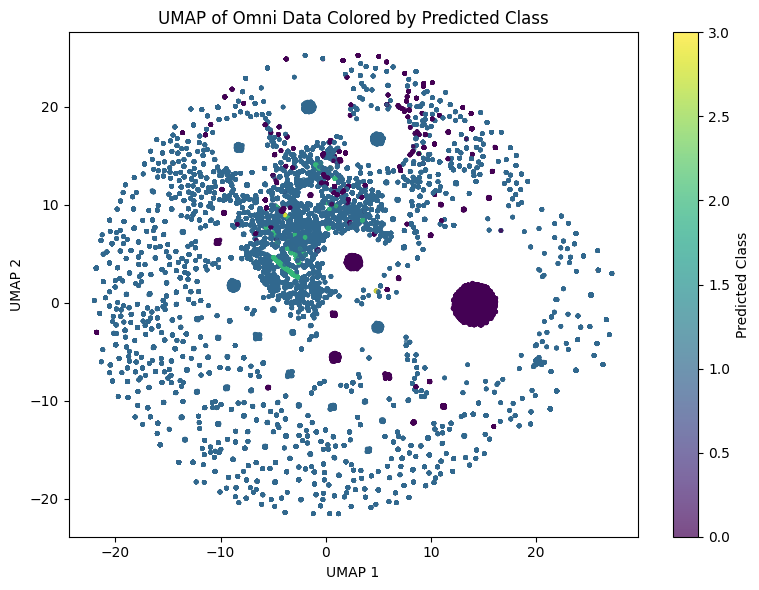

In [19]:
import umap
pca = umap.UMAP()
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

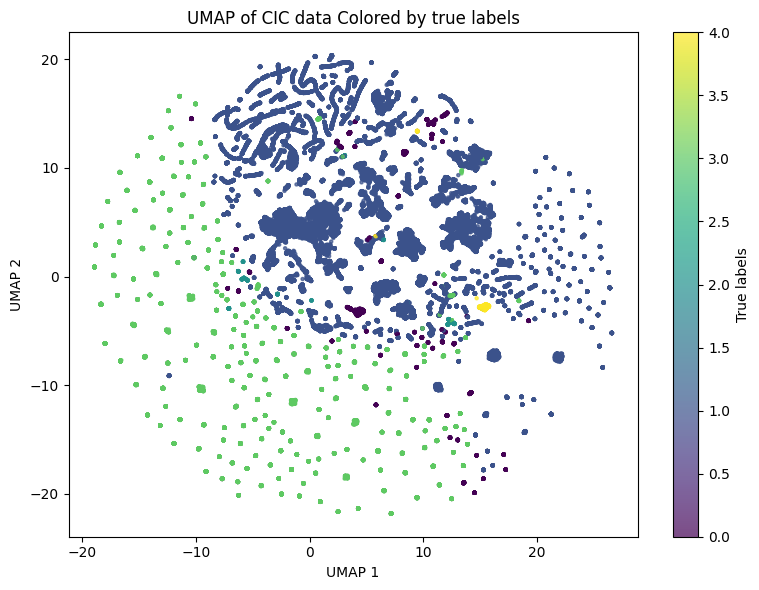

In [20]:
pca = umap.UMAP()
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of CIC data Colored by true labels')
plt.colorbar(scatter, label='True labels')
plt.tight_layout()
plt.show()

# here I want to make an analysis of the predictions based on the features especially teh commands that where extracted in the omni document

check if the predicted scan or ddos or other have commands that are expected os such attacks

In [21]:
df_analysis = grouped_df.copy()
df_analysis['predicted_label'] = omni_pred
cmd_cols = [col for col in df_analysis.columns if col.startswith('cmd_')]

# Get proportions per class
binary_feature_means = df_analysis.groupby('predicted_label')[cmd_cols].mean() *100

label_map = {
    0: 'BruteForce',
    1: 'DoS/DDoS',
    2: 'Other',
    3: 'Scan',
    4: 'WebAttack'
}

binary_feature_means = binary_feature_means.rename(index=label_map)

print(binary_feature_means.round(2))

                 cmd_wget_max  cmd_curl_max  cmd_chmod_max  cmd_dd_max  \
predicted_label                                                          
BruteForce               0.00          0.00           0.00        1.48   
DoS/DDoS                 0.17          0.55           0.14        0.13   
Other                    0.05          0.16           0.05        0.63   
Scan                     0.00          0.00           0.00        0.00   

                 cmd_http_over_ssh_max  cmd_scp_max  cmd_ftp_max  cmd_nc_max  \
predicted_label                                                                
BruteForce                        0.05         0.00         0.18        0.63   
DoS/DDoS                          0.83         0.44         1.00        4.05   
Other                             0.42         0.00         0.26        5.41   
Scan                              0.00         0.00         0.00        3.33   

                 cmd_tar_max  cmd_cp_max  ...  cmd_id_max  cmd_ping_max  \

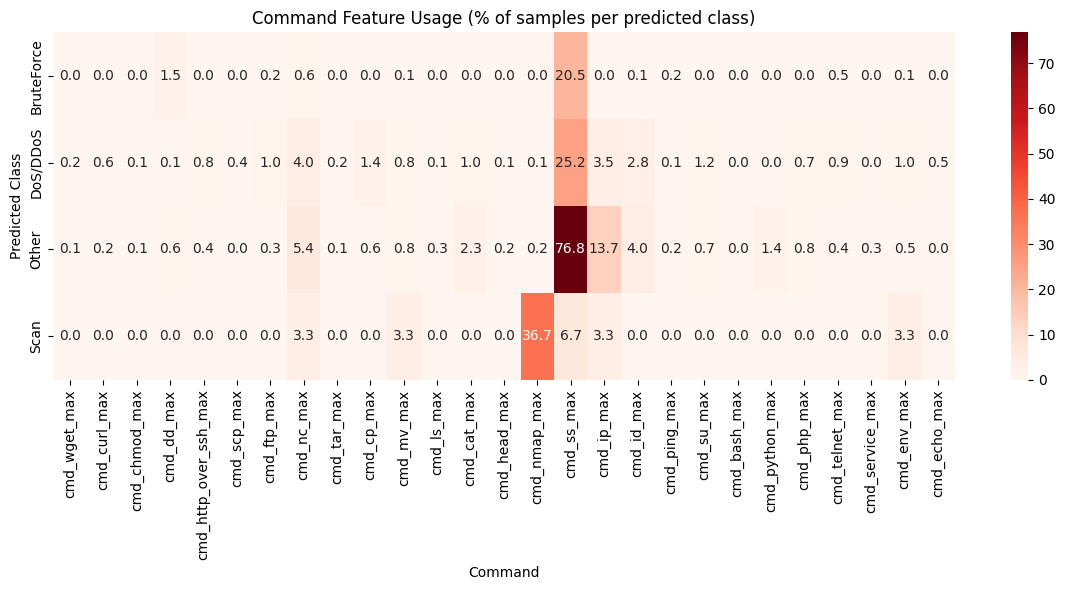

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(binary_feature_means, annot=True, cmap="Reds", fmt=".1f")
plt.title("Command Feature Usage (% of samples per predicted class)")
plt.xlabel("Command")
plt.ylabel("Predicted Class")
plt.tight_layout()
plt.show()

# Model with high confidence predictions

combined the data from the previous model and the very high confidence predictions of the moni data (>0.97) to then retrain and see if there is an improvement in the performance

In [28]:
confidence_threshold = 0.97

high_conf_samples = []
high_conf_labels = []

for class_idx in range(omni_probs.shape[1]):
    class_mask = (omni_pred == class_idx) & (omni_probs[:, class_idx] >= confidence_threshold)
    selected = x_grouped[class_mask]
    high_conf_samples.append(selected)
    high_conf_labels.extend([class_idx] * selected.shape[0])

if high_conf_samples:
    x_high_conf = pd.concat(high_conf_samples, axis=0)
    y_high_conf = np.array(high_conf_labels)
else:
    x_high_conf = pd.DataFrame()
    y_high_conf = np.array([])

print(f"Selected {len(y_high_conf)} high-confidence samples.")

from collections import Counter
class_counts = Counter(y_high_conf)
valid_classes = [c for c, count in class_counts.items() if count >= 2]

mask = np.isin(y_high_conf, valid_classes)
x_high_conf = x_high_conf[mask]
y_high_conf = y_high_conf[mask]

x_high_conf_train, x_test_aug, y_high_conf_train, y_test_aug = train_test_split(
    x_high_conf,
    y_high_conf,
    test_size=0.3,
    stratify=y_high_conf
)

x_train_aug = pd.concat([x_train, x_high_conf_train], axis=0)
y_train_aug = np.concatenate([y_train, y_high_conf_train], axis=0)

print(f"Training set size after augmentation: {len(x_train_aug)}, eval set size: {len(x_test_aug)}")


Selected 273098 high-confidence samples.
Training set size after augmentation: 636411, eval set size: 81930


In [29]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    objective='multi:softprob',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(x_train_aug, y_train_aug)

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [08:47:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [30]:
pred = xgb.predict(x_test)

augmented_pred = xgb.predict(x_test_aug)

omni_pred = xgb.predict(x_grouped)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2834
           1       1.00      1.00      1.00     75746
           2       0.98      0.99      0.98       388
           3       1.00      1.00      1.00     31850
           4       1.00      0.89      0.94       494

    accuracy                           1.00    111312
   macro avg       0.99      0.98      0.98    111312
weighted avg       1.00      1.00      1.00    111312



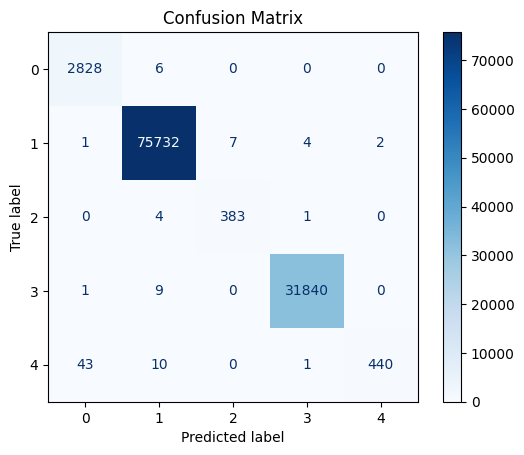

In [31]:
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41894
           1       1.00      1.00      1.00     40036

    accuracy                           1.00     81930
   macro avg       1.00      1.00      1.00     81930
weighted avg       1.00      1.00      1.00     81930



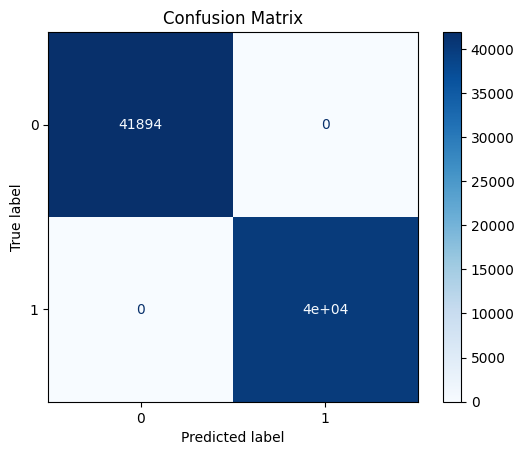

In [32]:
print(classification_report(y_test_aug, augmented_pred))

cm = confusion_matrix(y_test_aug, augmented_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [33]:
pd.Series(omni_pred).value_counts()

1    282906
0    146986
Name: count, dtype: int64

## PCA aumgented

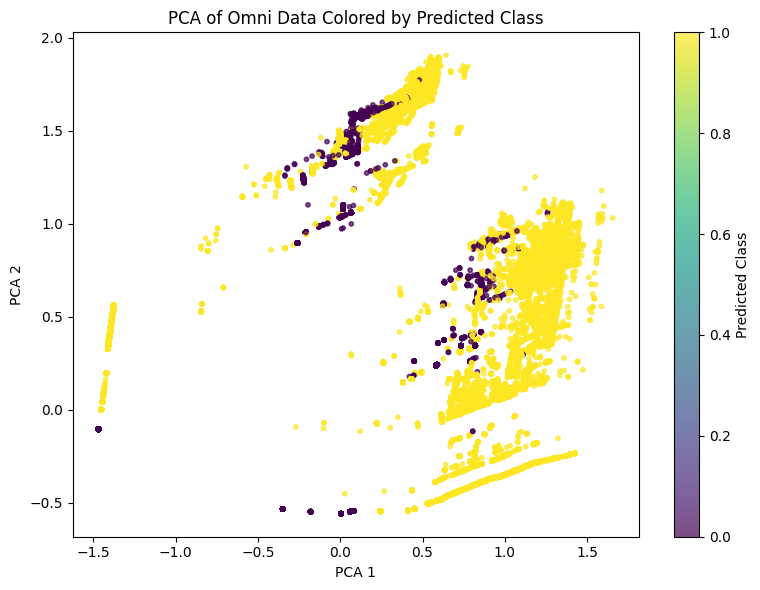

In [34]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

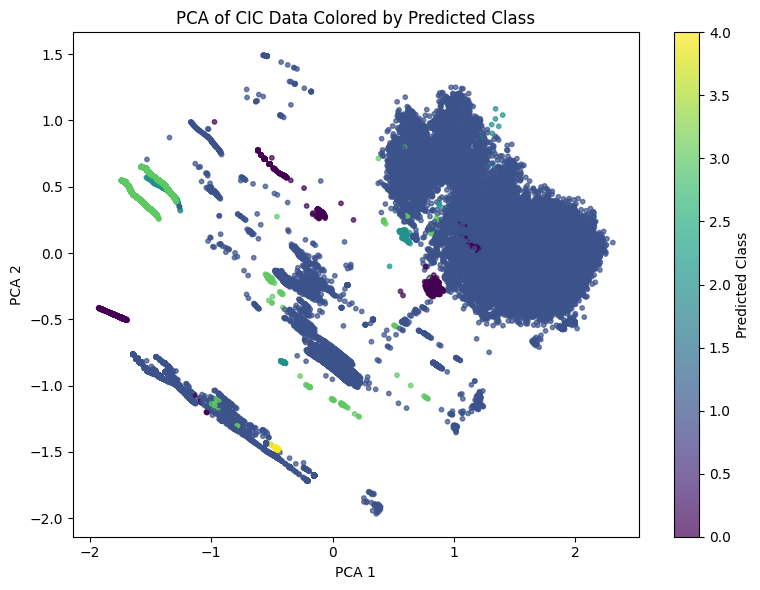

In [35]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=10)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of CIC Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

## UMAP augmented

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

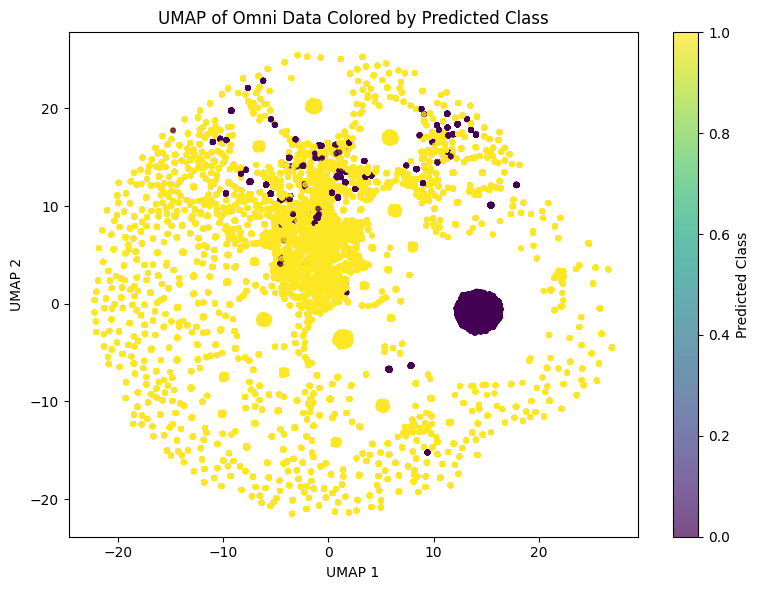

In [36]:
import umap
pca = umap.UMAP()
X_pca = pca.fit_transform(x_grouped)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=omni_pred, alpha=0.7, s=10)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of Omni Data Colored by Predicted Class')
plt.colorbar(scatter, label='Predicted Class')
plt.tight_layout()
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

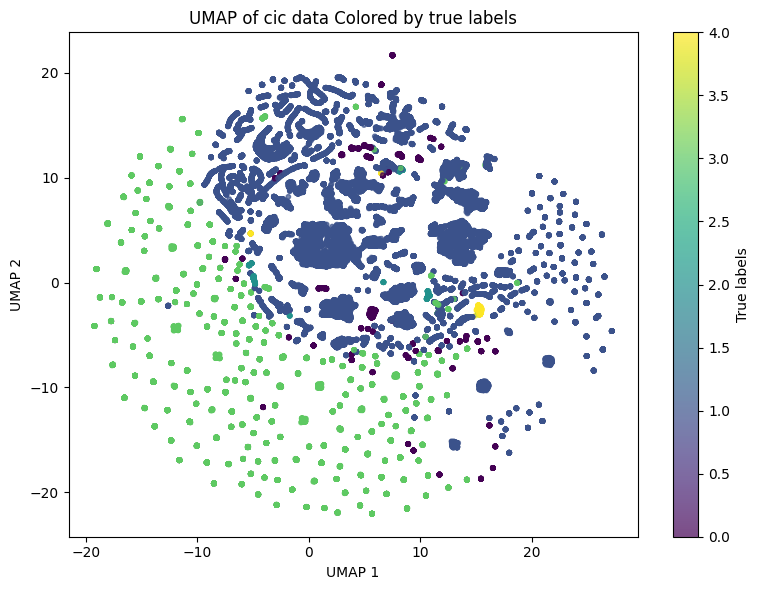

In [37]:
pca = umap.UMAP()
X_pca = pca.fit_transform(x_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, alpha=0.7, s=10)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP of cic data Colored by true labels')
plt.colorbar(scatter, label='True labels')
plt.tight_layout()
plt.show()

In [38]:
df_analysis = grouped_df.copy()
df_analysis['predicted_label'] = omni_pred
cmd_cols = [col for col in df_analysis.columns if col.startswith('cmd_')]

# Get proportions per class
binary_feature_means = df_analysis.groupby('predicted_label')[cmd_cols].mean() *100

label_map = {
    0: 'BruteForce',
    1: 'DoS/DDoS',
    2: 'Other',
    3: 'Scan',
    4: 'WebAttack'
}

binary_feature_means = binary_feature_means.rename(index=label_map)

print(binary_feature_means.round(2))

                 cmd_wget_max  cmd_curl_max  cmd_chmod_max  cmd_dd_max  \
predicted_label                                                          
BruteForce               0.00          0.00           0.00        0.00   
DoS/DDoS                 0.14          0.44           0.11        1.17   

                 cmd_http_over_ssh_max  cmd_scp_max  cmd_ftp_max  cmd_nc_max  \
predicted_label                                                                
BruteForce                        0.05         0.00         0.07        0.06   
DoS/DDoS                          0.67         0.35         0.89        3.67   

                 cmd_tar_max  cmd_cp_max  ...  cmd_id_max  cmd_ping_max  \
predicted_label                           ...                             
BruteForce              0.00        0.01  ...        0.04          0.09   
DoS/DDoS                0.13        1.10  ...        2.27          0.17   

                 cmd_su_max  cmd_bash_max  cmd_python_max  cmd_php_max  \
predict

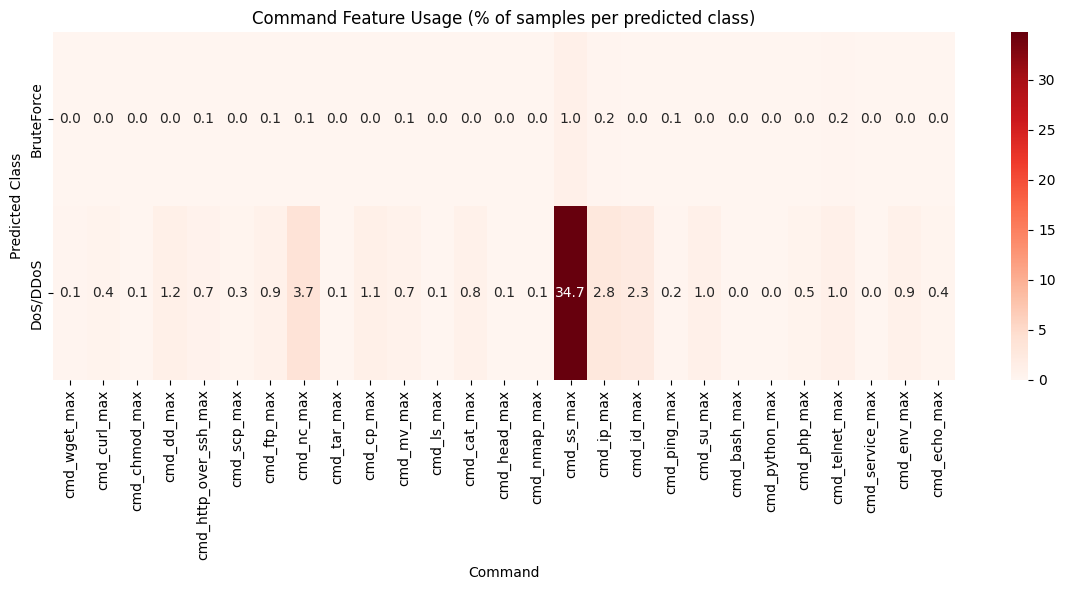

In [39]:
plt.figure(figsize=(12, 6))
sns.heatmap(binary_feature_means, annot=True, cmap="Reds", fmt=".1f")
plt.title("Command Feature Usage (% of samples per predicted class)")
plt.xlabel("Command")
plt.ylabel("Predicted Class")
plt.tight_layout()
plt.show()